In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
data = pd.read_csv('train.csv')

# Tratamiento de calidad y limpieza de datos

In [77]:
# Revisión de valores nulos
print("Valores nulos por columna:")
print(data.isnull().sum())
print("\nPorcentaje de valores nulos por columna:")
print(data.isnull().sum()/len(data) * 100)

# Revisión de duplicados
duplicados = data.duplicated().sum()
print(f"\nNúmero de registros duplicados: {duplicados}")

# Revisión de tipos de datos
print("\nTipos de datos de las columnas:")
print(data.dtypes)

Valores nulos por columna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Porcentaje de valores nulos por columna:
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Número de registros duplicados: 0

Tipos de datos de las columnas:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [78]:
# Poner la columna 'Age' mediante KNN imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data['Age'] = imputer.fit_transform(data[['Age', 'Pclass', 'Fare']])[:, 0]

# Poner la columna 'Embarked' con la moda
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Poner la columna 'Cabin' con "Unknown" 
data['Cabin'] = data['Cabin'].fillna("Unknown")

Se aplico KNN imputer porque es un metodo robusto que toma en cuenta mas variables

In [79]:
import re

def extraer_titulo_robusto(nombre):
    """
    Función robusta para extraer títulos/gentilicios de nombres completos.
    
    Parámetros:
    nombre (str): Nombre completo de la persona
    
    Retorna:
    str: Título extraído y normalizado
    """
    if pd.isna(nombre) or not isinstance(nombre, str):
        return 'Unknown'
    
    # Diccionario de mapeo para normalizar títulos
    titulo_mapping = {
        # Títulos masculinos
        'Mr': 'Mr',
        'Master': 'Master',
        'Rev': 'Rev',
        'Dr': 'Dr',
        'Major': 'Military',
        'Col': 'Military',
        'Capt': 'Military',
        'Sir': 'Nobility',
        'Don': 'Nobility',
        'Jonkheer': 'Nobility',
        
        # Títulos femeninos
        'Mrs': 'Mrs',
        'Miss': 'Miss',
        'Ms': 'Miss',
        'Mme': 'Mrs',
        'Mlle': 'Miss',
        'Lady': 'Nobility',
        'Countess': 'Nobility',
        'Dona': 'Nobility',
        
        # Títulos profesionales
        'Prof': 'Dr',
        'Doctor': 'Dr',
        'Professor': 'Dr'
    }
    
    # Patrón regex para encontrar títulos
    # Busca palabras que terminan en punto o están seguidas de un espacio/punto
    patron = r'\b([A-Za-z]+\.?)\s'
    
    # Buscar todos los posibles títulos
    matches = re.findall(patron, nombre)
    
    for match in matches:
        # Limpiar el match (quitar puntos)
        titulo_limpio = match.replace('.', '')
        
        # Verificar si es un título conocido
        if titulo_limpio in titulo_mapping:
            return titulo_mapping[titulo_limpio]
        
        # Verificar variaciones comunes
        titulo_lower = titulo_limpio.lower()
        for key in titulo_mapping.keys():
            if titulo_lower == key.lower():
                return titulo_mapping[key]
    
    # Si no se encuentra un título específico, intentar con patrones más generales
    # Buscar palabras entre comas (formato: Apellido, Título. Nombre)
    if ',' in nombre:
        partes = nombre.split(',')
        if len(partes) >= 2:
            segunda_parte = partes[1].strip()
            # Buscar título en la segunda parte
            titulo_match = re.search(r'\b([A-Za-z]+)', segunda_parte)
            if titulo_match:
                titulo_encontrado = titulo_match.group(1)
                if titulo_encontrado in titulo_mapping:
                    return titulo_mapping[titulo_encontrado]
    
    # Como último recurso, categorizar por patrones de género
    nombre_lower = nombre.lower()
    if any(fem in nombre_lower for fem in ['miss', 'mrs', 'ms', 'lady', 'mme', 'mlle']):
        return 'Miss' if 'miss' in nombre_lower or 'mlle' in nombre_lower else 'Mrs'
    elif any(masc in nombre_lower for masc in ['mr', 'master', 'sir', 'don']):
        return 'Master' if 'master' in nombre_lower else 'Mr'
    
    return 'Unknown'

# Aplicar la función al dataset
data['Titulo'] = data['Name'].apply(extraer_titulo_robusto)

# Mostrar la distribución de títulos extraídos
print("Distribución de Títulos Extraídos:")
print("="*40)
print(data['Titulo'].value_counts())

# Mostrar algunos ejemplos
print("\nEjemplos de extracción:")
print("="*40)
ejemplos = data[['Name', 'Titulo']].head(10)
for idx, row in ejemplos.iterrows():
    print(f"Nombre: {row['Name']}")
    print(f"Título: {row['Titulo']}")
    print("-" * 50)

Distribución de Títulos Extraídos:
Titulo
Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Nobility      5
Military      5
Name: count, dtype: int64

Ejemplos de extracción:
Nombre: Braund, Mr. Owen Harris
Título: Mr
--------------------------------------------------
Nombre: Cumings, Mrs. John Bradley (Florence Briggs Thayer)
Título: Mrs
--------------------------------------------------
Nombre: Heikkinen, Miss. Laina
Título: Miss
--------------------------------------------------
Nombre: Futrelle, Mrs. Jacques Heath (Lily May Peel)
Título: Mrs
--------------------------------------------------
Nombre: Allen, Mr. William Henry
Título: Mr
--------------------------------------------------
Nombre: Moran, Mr. James
Título: Mr
--------------------------------------------------
Nombre: McCarthy, Mr. Timothy J
Título: Mr
--------------------------------------------------
Nombre: Palsson, Master. Gosta Leonard
Título: Master
---------------------

# Análisis Univariado

## Variables cuantitativas

In [80]:
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']

In [81]:
from scipy.stats import skew, kurtosis, shapiro

def plot_numeric_distributions(data, numeric_cols):  
    cols_per_row = 2
    n = len(numeric_cols)
    rows = -(-n // cols_per_row)  

    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    for idx, col in enumerate(numeric_cols, 1):
        sk = skew(data[col].dropna())
        kt = kurtosis(data[col].dropna())
        _, p = shapiro(data[col].dropna())

        plt.subplot(rows, cols_per_row*2, idx*2-1)
        sns.histplot(data[col], kde=True, bins=20, color="skyblue")
        plt.title(f"{col}\nSkew: {sk:.2f}, Kurt: {kt:.2f}, p={p:.2g}")

        plt.subplot(rows, cols_per_row*2, idx*2)
        sns.boxplot(y=data[col], color="lightcoral")
        plt.title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()

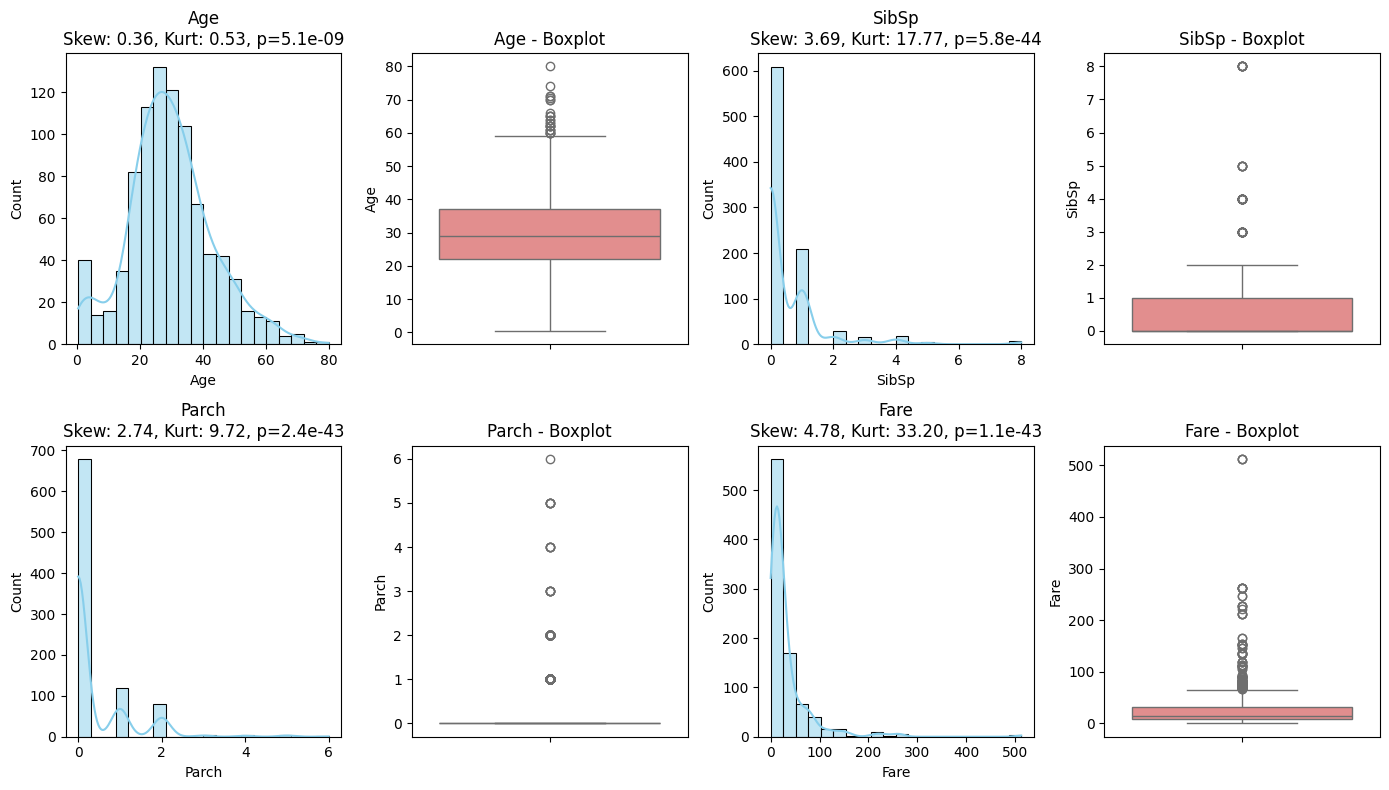

In [82]:
plot_numeric_distributions(data, numeric_cols)

Como primeras observaciones para las variables cuantitativa continuas Age y Fare podemos observar asimetría
positiva en ambos casos, es decir las edades se suelen concentrar en valores
bajos, esto es visualmente claro en el histograma de Fare. Por otro lado, Age
presenta una kurtosis baja mientras que Fare tiene una muy alta. La alta Kurtosis de fare también se puede observar en su boxplot puesto que hay una alta
cantidad de outliers encima del límite superior.

En humano, las tarifas de los pasajeros tienen un sesgo hacia los valores más bajos, por lo que tarifas con precios elevados son raras. Respecto a la edad, esta tiene un ligero sesgo hacia los valores bajos y edades mayores a 65 son atípicas.

## Variables cualitativas

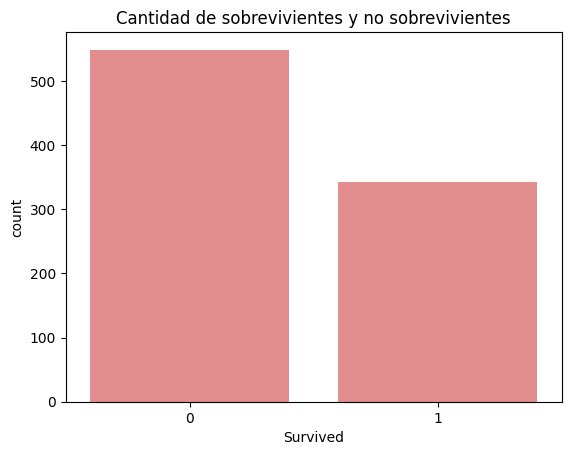

In [83]:
sns.countplot(x='Survived', data=data,color='lightcoral')
plt.title('Cantidad de sobrevivientes y no sobrevivientes')
plt.show()

Observamos que la cantidad de no supervivientes es mayor a la de supervivientes y está un poco desbalanceada

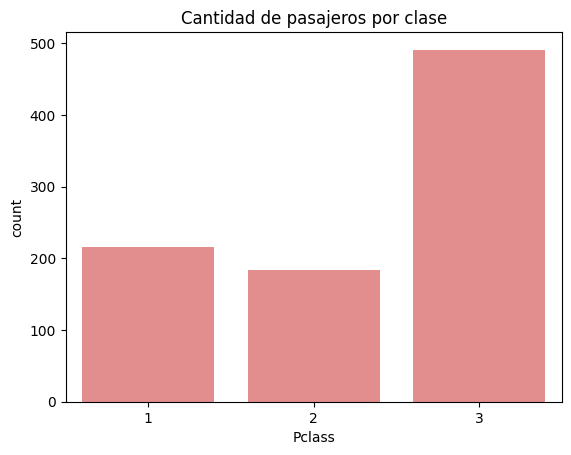

In [84]:
sns.countplot(x='Pclass', data=data, color='lightcoral')
plt.title('Cantidad de pasajeros por clase')
plt.show()

Observamos que la cantidad de pasajeros en tercera clase es mayor.

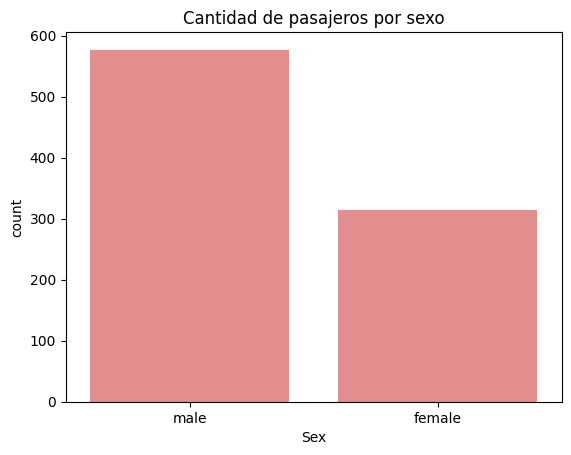

In [85]:
sns.countplot(x='Sex', data=data, color='lightcoral')
plt.title('Cantidad de pasajeros por sexo')
plt.show()

In [86]:
men = len(data[data['Sex']=='male'])/len(data)
women = len(data[data['Sex']=='female'])/len(data)
print(men,women)

0.6475869809203143 0.35241301907968575


Observamos que la cantidad de pasajeros hombres es mayor a la de las mujeres, el 64% son hombres y el 35% mujeres

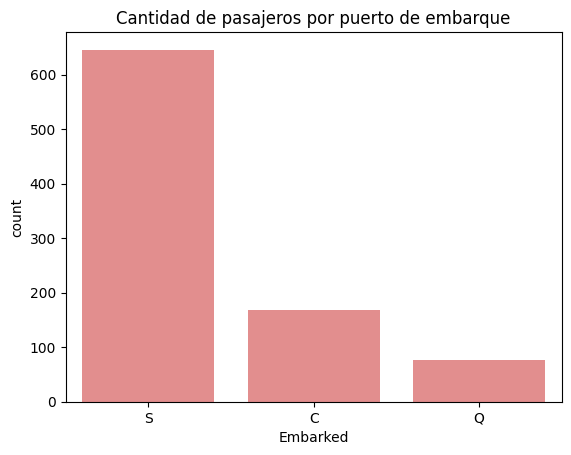

In [87]:
sns.countplot(x='Embarked', data=data, color='lightcoral')
plt.title('Cantidad de pasajeros por puerto de embarque')
plt.show()

La cantidad de pasajeros provenientes del puerto S es bastante mayor a los que provienen del puerto C y Q respectivamente

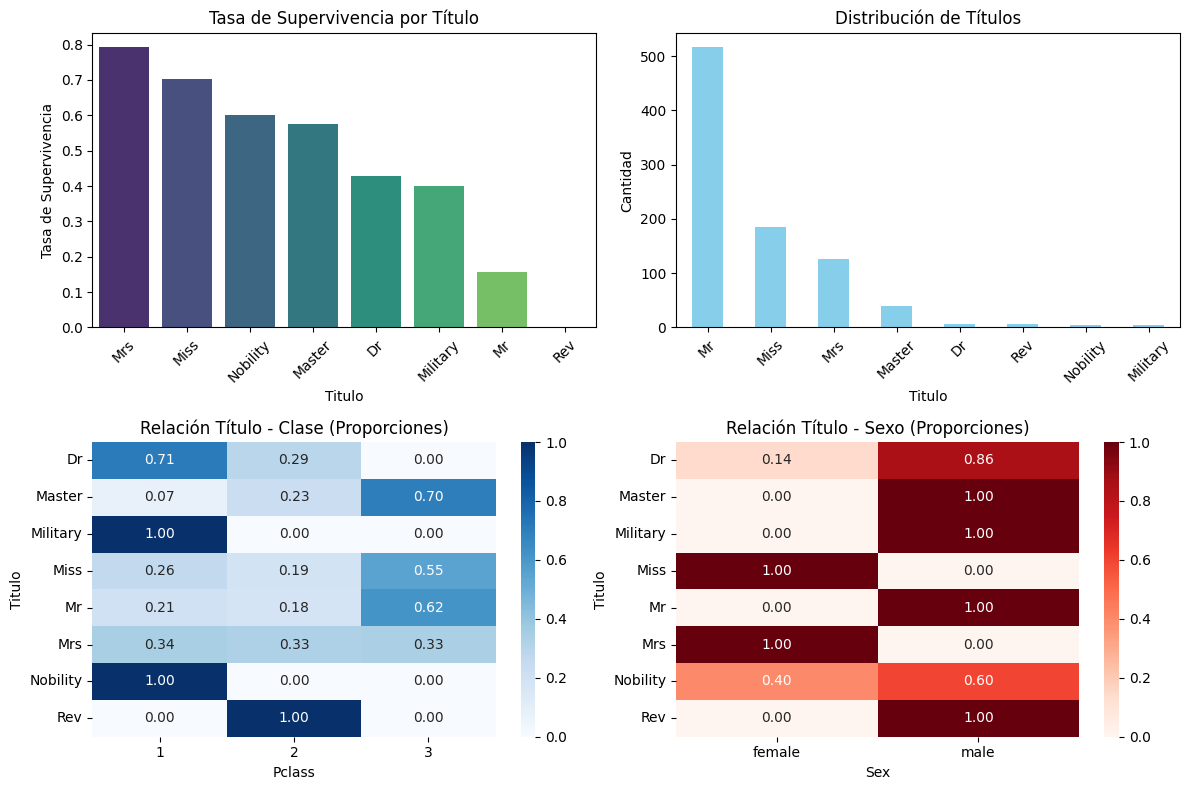


Tabla Resumen: Títulos y Supervivencia
          Total  Sobrevivientes  Tasa_Supervivencia  Edad_Promedio  \
Titulo                                                               
Mrs         126             100                0.79          35.02   
Miss        185             130                0.70          23.24   
Nobility      5               3                0.60          41.60   
Master       40              23                0.57           6.86   
Dr            7               3                0.43          41.91   
Military      5               2                0.40          56.60   
Mr          517              81                0.16          32.13   
Rev           6               0                0.00          43.17   

          Tarifa_Promedio  
Titulo                     
Mrs                 45.33  
Miss                43.80  
Nobility            42.15  
Master              34.70  
Dr                  49.17  
Military            38.02  
Mr                  24.44  
Rev    

In [88]:
# Análisis de supervivencia por título
plt.figure(figsize=(12, 8))

# Gráfico de barras de supervivencia por título
plt.subplot(2, 2, 1)
titulo_survival = data.groupby('Titulo')['Survived'].agg(['count', 'sum']).reset_index()
titulo_survival['survival_rate'] = titulo_survival['sum'] / titulo_survival['count']
titulo_survival = titulo_survival.sort_values('survival_rate', ascending=False)

sns.barplot(data=titulo_survival, x='Titulo', y='survival_rate', palette='viridis')
plt.title('Tasa de Supervivencia por Título')
plt.ylabel('Tasa de Supervivencia')
plt.xticks(rotation=45)

# Distribución de títulos
plt.subplot(2, 2, 2)
data['Titulo'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de Títulos')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Relación entre título y clase
plt.subplot(2, 2, 3)
titulo_clase = pd.crosstab(data['Titulo'], data['Pclass'], normalize='index')
sns.heatmap(titulo_clase, annot=True, fmt='.2f', cmap='Blues')
plt.title('Relación Título - Clase (Proporciones)')

# Relación entre título y sexo
plt.subplot(2, 2, 4)
titulo_sexo = pd.crosstab(data['Titulo'], data['Sex'], normalize='index')
sns.heatmap(titulo_sexo, annot=True, fmt='.2f', cmap='Reds')
plt.title('Relación Título - Sexo (Proporciones)')

plt.tight_layout()
plt.show()

# Tabla resumen de títulos y supervivencia
print("\nTabla Resumen: Títulos y Supervivencia")
print("="*50)
resumen_titulos = data.groupby('Titulo').agg({
    'Survived': ['count', 'sum', 'mean'],
    'Age': 'mean',
    'Fare': 'mean'
}).round(2)

resumen_titulos.columns = ['Total', 'Sobrevivientes', 'Tasa_Supervivencia', 'Edad_Promedio', 'Tarifa_Promedio']
print(resumen_titulos.sort_values('Tasa_Supervivencia', ascending=False))

# Análisis Multivariado

## Multivariado cuantitativas vs cuantitativas

In [89]:
corr_spearman = data[numeric_cols].corr(method='spearman')

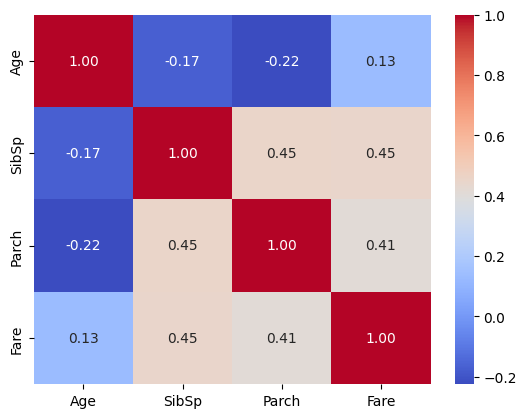

In [90]:
sns.heatmap(data[numeric_cols].corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

A partir del estadístico de spearman observamos que las correlación no son fuertes. Aun faltando probar su significancia estadística

In [91]:
num_cols = data[numeric_cols]

In [92]:
from scipy.stats import spearmanr
import numpy as np

def get_spearman_pvalues(df):
    """Calcula matriz de p-valores para correlaciones de Spearman"""
    cols = df.columns
    n = len(cols)
    p_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                p_matrix[i, j] = 0  # Diagonal siempre 0
            else:
                # Eliminar NaN para el cálculo
                x = df.iloc[:, i].dropna()
                y = df.iloc[:, j].dropna()
                # Encontrar índices comunes (sin NaN en ambas variables)
                common_idx = df[[cols[i], cols[j]]].dropna().index
                if len(common_idx) > 2:
                    corr, p_val = spearmanr(df.loc[common_idx, cols[i]], 
                                          df.loc[common_idx, cols[j]])
                    p_matrix[i, j] = p_val
                else:
                    p_matrix[i, j] = np.nan
    
    return pd.DataFrame(p_matrix, index=cols, columns=cols)

# Calcular matriz de p-valores
p_values_spearman = get_spearman_pvalues(num_cols)

# Crear lista de pares únicos (sin repetir)
pairs_data = []
cols = num_cols.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        var1, var2 = cols[i], cols[j]
        corr = corr_spearman.loc[var1, var2]
        p_val = p_values_spearman.loc[var1, var2]
        
        # Clasificar fuerza de correlación
        abs_corr = abs(corr)
        if abs_corr < 0.1:
            fuerza = "Muy débil"
        elif abs_corr < 0.3:
            fuerza = "Débil"
        elif abs_corr < 0.5:
            fuerza = "Moderada"
        elif abs_corr < 0.7:
            fuerza = "Fuerte"
        else:
            fuerza = "Muy fuerte"
            
        pairs_data.append({
            'Par_Variables': f"{var1} ↔ {var2}",
            'Spearman_ρ': corr,
            'p-valor': p_val,
            'Significativo_α05': 'Sí' if p_val < 0.05 else 'No',
            'Fuerza': fuerza
        })

# Crear DataFrame y ordenar por p-valor
correlations_df = pd.DataFrame(pairs_data)
correlations_df = correlations_df.sort_values('p-valor')

# Redondear valores para mejor legibilidad
correlations_df['Spearman_ρ'] = correlations_df['Spearman_ρ'].round(4)
correlations_df['p-valor'] = correlations_df['p-valor'].round(6)

display(correlations_df)


,Par_Variables,Spearman_ρ,p-valor,Significativo_α05,Fuerza
3,SibSp ↔ Parch,0.4500,0.000000,Sí,Moderada
4,SibSp ↔ Fare,0.4471,0.000000,Sí,Moderada
5,Parch ↔ Fare,0.4101,0.000000,Sí,Moderada
1,Age ↔ Parch,-0.2246,0.000000,Sí,Débil
0,Age ↔ SibSp,-0.1673,0.000001,Sí,Débil
2,Age ↔ Fare,0.1300,0.000100,Sí,Débil


Observamos que el p value indica que las correlaciones son significativa, sin embargo, debido a que el estadístico no es mayor a 0.5 no son correlaciones fuertes.

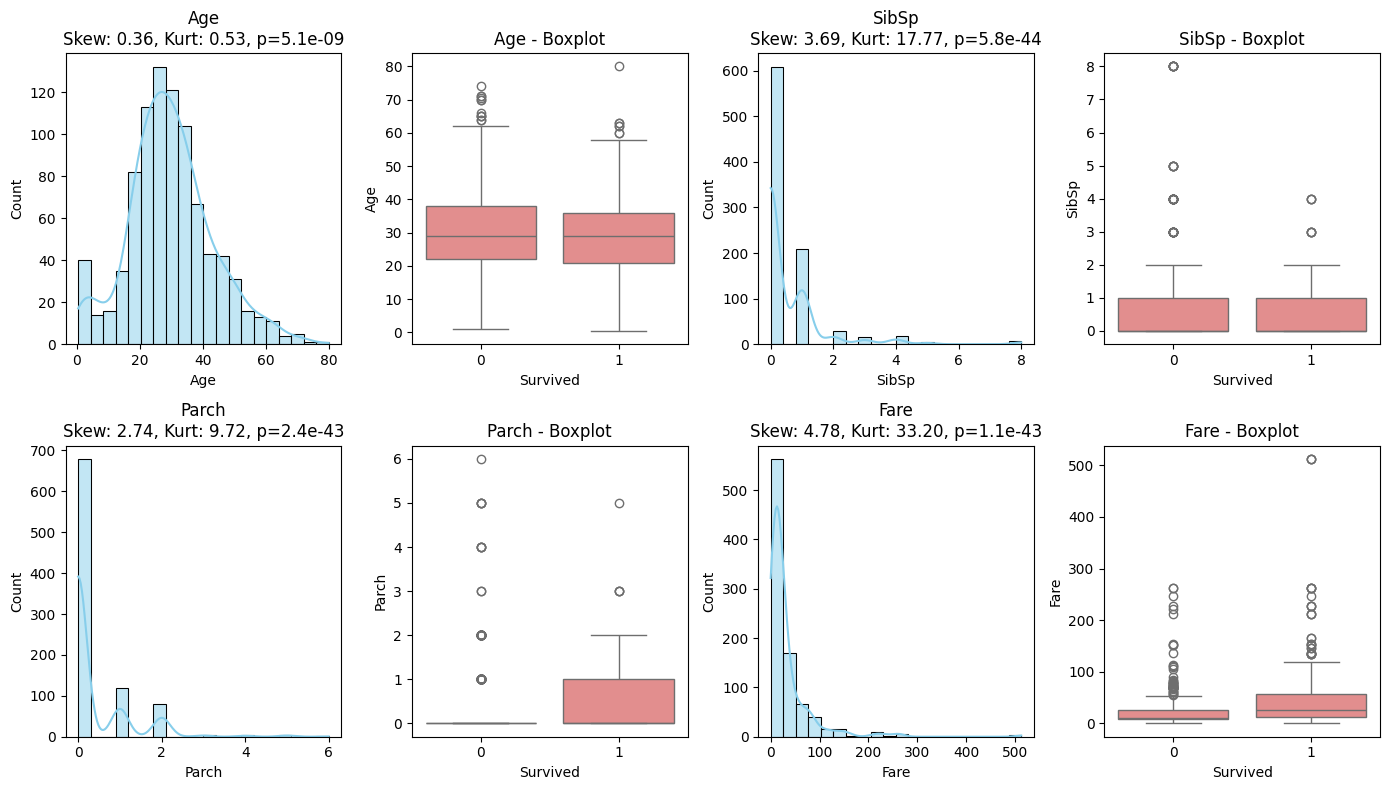

In [93]:
# Función para visualizar distribuciones numéricas y boxplots
def plot_numeric_distributions_by_class(data, numeric_cols):  
    cols_per_row = 2  # Número de columnas por fila
    n = len(numeric_cols)  # Total de columnas numéricas
    rows = -(-n // cols_per_row)  # Calcular número de filas (división hacia arriba)

    # Configuración de la figura
    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    # Iterar sobre las columnas numéricas
    for idx, col in enumerate(numeric_cols, 1):
        # Calcular skew, kurtosis y realizar la prueba de normalidad (Shapiro)
        sk = skew(data[col].dropna())
        kt = kurtosis(data[col].dropna())
        _, p = shapiro(data[col].dropna())

        # Histograma y KDE
        plt.subplot(rows, cols_per_row * 2, idx * 2 - 1)
        sns.histplot(data[col], kde=True, bins=20, color="skyblue")
        plt.title(f"{col}\nSkew: {sk:.2f}, Kurt: {kt:.2f}, p={p:.2g}")

        # Boxplot para detectar atípicos
        plt.subplot(rows, cols_per_row * 2, idx * 2)
        sns.boxplot(x=data['Survived'], y=data[col], color="lightcoral")
        plt.title(f"{col} - Boxplot")

    # Ajustar los gráficos
    plt.tight_layout()
    plt.show()


plot_numeric_distributions_by_class(data, numeric_cols)

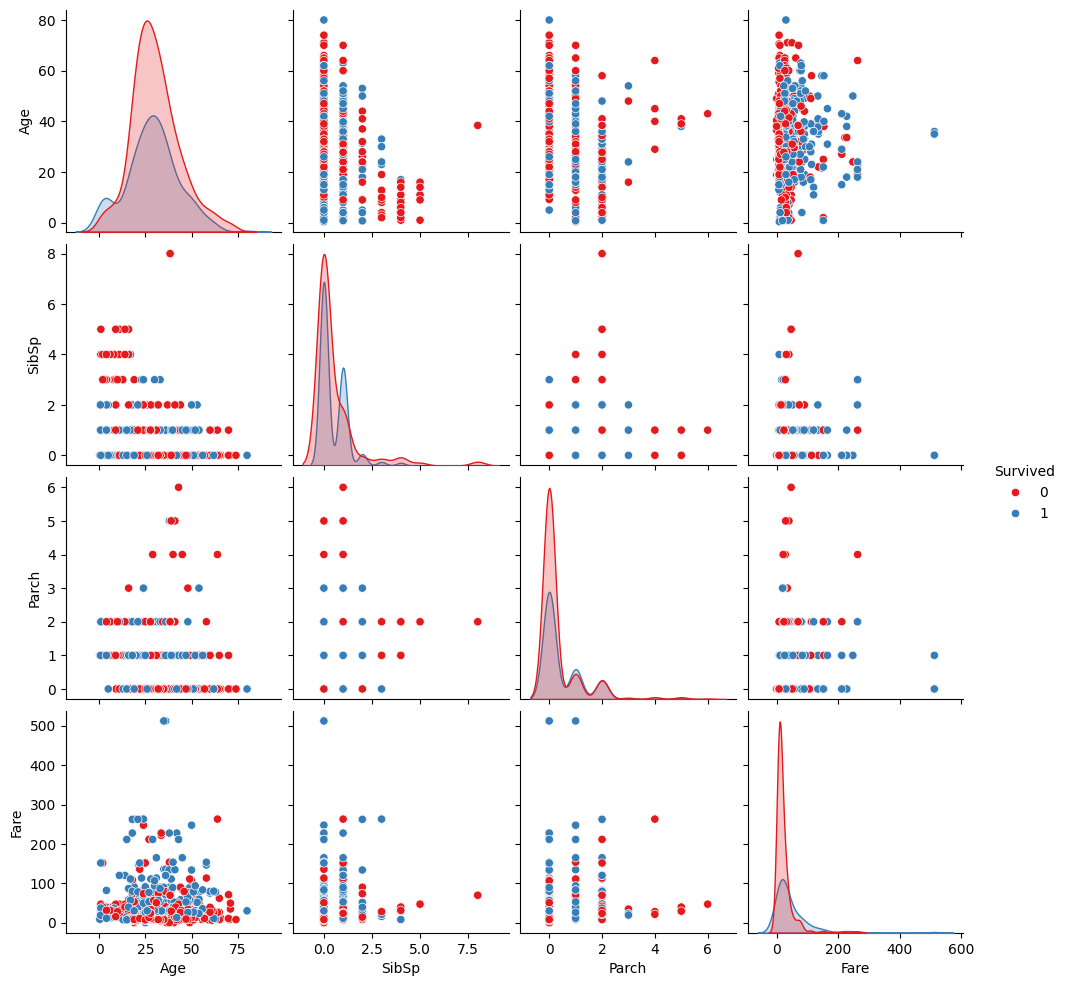

In [94]:
sns.pairplot(data, hue='Survived', vars=numeric_cols, palette='Set1')

## Multivariado cuantitativas vs cualitativas

**Nota:** Aunque parch y sibsp sean cuantitativas discretas, se mantendran como variables numéricas ya que se usará un random forest

In [95]:
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal

# --- t-test (Welch) y Mann–Whitney: Age por Survived (0 vs 1) ---
age_surv0 = data.loc[data["Survived"]==0, "Age"].dropna()
age_surv1 = data.loc[data["Survived"]==1, "Age"].dropna()

# Welch t-test (no asume varianzas iguales)
stat_t_age, p_t_age = ttest_ind(age_surv0, age_surv1, equal_var=False)

# Efecto (Cohen's d; pooled sd)
def cohens_d(x, y):
    n1, n2 = len(x), len(y)
    s1, s2 = x.var(ddof=1), y.var(ddof=1)
    s_p = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2))
    return (x.mean() - y.mean()) / s_p

d_age = cohens_d(age_surv0, age_surv1)

# No paramétrico (Mann–Whitney U)
stat_mw_age, p_mw_age = mannwhitneyu(age_surv0, age_surv1, alternative="two-sided")

# --- t-test / Mann–Whitney: Fare por Sex (male vs female) ---
fare_male   = data.loc[data["Sex"]=="male", "Fare"].dropna()
fare_female = data.loc[data["Sex"]=="female", "Fare"].dropna()

stat_t_fare, p_t_fare = ttest_ind(fare_male, fare_female, equal_var=False)
d_fare = cohens_d(fare_male, fare_female)

stat_mw_fare, p_mw_fare = mannwhitneyu(fare_male, fare_female, alternative="two-sided")

# --- ANOVA y Kruskal–Wallis: Fare por Pclass (1,2,3) ---
classes = sorted(data["Pclass"].dropna().unique())
fare_groups = [data.loc[data["Pclass"]==c, "Fare"].dropna().values for c in classes]

# ANOVA (one-way)
stat_f, p_f = f_oneway(*fare_groups)

# Eta^2 desde F (aprox.)
k = len(fare_groups)
n = sum(len(g) for g in fare_groups)
eta2 = (stat_f * (k - 1)) / (stat_f * (k - 1) + (n - k))

# Kruskal–Wallis (no paramétrico)
stat_kw, p_kw = kruskal(*fare_groups)
                  

In [96]:
resultados_stats = pd.DataFrame({
    'Prueba': [
        'T-test (Age ~ Survived)',
        'Mann-Whitney (Age ~ Survived)', 
        'T-test (Fare ~ Sex)',
        'Mann-Whitney (Fare ~ Sex)',
        'ANOVA (Fare ~ Pclass)',
        'Kruskal-Wallis (Fare ~ Pclass)'
    ],
    'Estadístico': [
        stat_t_age,
        stat_mw_age,
        stat_t_fare,
        stat_mw_fare,
        stat_f,
        stat_kw
    ],
    'p-valor': [
        p_t_age,
        p_mw_age,
        p_t_fare,
        p_mw_fare,
        p_f,
        p_kw
    ],
    'Tamaño_efecto': [
        f"Cohen's d = {d_age:.3f}",
        f"U = {stat_mw_age}",
        f"Cohen's d = {d_fare:.3f}",
        f"U = {stat_mw_fare}",
        f"η² = {eta2:.3f}",
        f"H = {stat_kw:.3f}"
    ],
    'Significativo_α05': [
        'Sí' if p_t_age < 0.05 else 'No',
        'Sí' if p_mw_age < 0.05 else 'No',
        'Sí' if p_t_fare < 0.05 else 'No',
        'Sí' if p_mw_fare < 0.05 else 'No',
        'Sí' if p_f < 0.05 else 'No',
        'Sí' if p_kw < 0.05 else 'No'
    ]
})

resultados_stats['p-valor'] = resultados_stats['p-valor'].round(6)

display(resultados_stats)

,Prueba,Estadístico,p-valor,Tamaño_efecto,Significativo_α05
0,T-test (Age ~ Survived),1.813656,0.070173,Cohen's d = 0.127,No
1,Mann-Whitney (Age ~ Survived),97910.500000,0.280502,U = 97910.5,No
2,T-test (Fare ~ Sex),-5.077499,0.000001,Cohen's d = -0.388,Sí
3,Mann-Whitney (Fare ~ Sex),62175.000000,0.000000,U = 62175.0,Sí
4,ANOVA (Fare ~ Pclass),242.344157,0.000000,η² = 0.353,Sí
5,Kruskal-Wallis (Fare ~ Pclass),438.043703,0.000000,H = 438.044,Sí


La prueba no paramétrica demuestra que la edad no es un factor
determinante. Ambas pruebas muestran que hay una diferencia significativa en las
tarifas por sexo. Las clase del pasaje explica en gran medida la variación en tarifas

## Multivariado cualitativas vs cualitativas

In [97]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def realizar_pruebas_chi2(data, variables_categoricas, target='Survived', alpha=0.05):
    """
    Realiza pruebas chi-cuadrado para variables categóricas vs target.
    
    Parámetros:
    data: DataFrame con los datos
    variables_categoricas: Lista de variables categóricas a probar
    target: Variable objetivo (por defecto 'Survived')
    alpha: Nivel de significancia (por defecto 0.05)
    
    Retorna:
    DataFrame con los resultados de las pruebas
    """
    resultados = []
    
    print("PRUEBAS CHI-CUADRADO PARA VARIABLES CATEGÓRICAS")
    print("=" * 60)
    
    for variable in variables_categoricas:
        # Crear tabla de contingencia
        tabla_contingencia = pd.crosstab(data[variable], data[target])
        
        # Realizar prueba chi-cuadrado
        chi2_stat, p_value, dof, expected = chi2_contingency(tabla_contingencia)
        
        # Calcular el valor crítico
        valor_critico = chi2.ppf(1 - alpha, dof)
        
        # Determinar si es significativo
        es_significativo = p_value < alpha
        
        # Calcular V de Cramer (medida del tamaño del efecto)
        n = tabla_contingencia.sum().sum()
        v_cramer = np.sqrt(chi2_stat / (n * (min(tabla_contingencia.shape) - 1)))
        
        # Guardar resultados
        resultado = {
            'Variable': variable,
            'Chi2_Estadistico': chi2_stat,
            'p_value': p_value,
            'Grados_Libertad': dof,
            'Valor_Critico': valor_critico,
            'Es_Significativo': es_significativo,
            'V_Cramer': v_cramer,
            'Interpretacion': 'Rechazar H0' if es_significativo else 'No rechazar H0'
        }
        resultados.append(resultado)
        
        # Mostrar resultados detallados
        print(f"\nVariable: {variable}")
        print(f"Chi² = {chi2_stat:.4f}")
        print(f"p-value = {p_value:.6f}")
        print(f"Grados de libertad = {dof}")
        print(f"Valor crítico (α={alpha}) = {valor_critico:.4f}")
        print(f"V de Cramer = {v_cramer:.4f}")
        print(f"Resultado: {resultado['Interpretacion']}")
        
        # Mostrar tabla de contingencia
        print(f"\nTabla de Contingencia para {variable}:")
        print(tabla_contingencia)
        
        # Mostrar frecuencias esperadas
        print(f"\nFrecuencias Esperadas para {variable}:")
        expected_df = pd.DataFrame(expected, 
                                 index=tabla_contingencia.index, 
                                 columns=tabla_contingencia.columns)
        print(expected_df.round(2))
        print("-" * 50)
    
    # Crear DataFrame con todos los resultados
    df_resultados = pd.DataFrame(resultados)
    
    return df_resultados

# Definir variables categóricas para el análisis
variables_categoricas = ['Sex', 'Pclass', 'Embarked', 'Titulo']

# Realizar las pruebas chi-cuadrado
resultados_chi2 = realizar_pruebas_chi2(data, variables_categoricas)

print(resultados_chi2[['Variable', 'Chi2_Estadistico', 'p_value', 'Es_Significativo', 'V_Cramer']].round(4))

PRUEBAS CHI-CUADRADO PARA VARIABLES CATEGÓRICAS

Variable: Sex
Chi² = 260.7170
p-value = 0.000000
Grados de libertad = 1
Valor crítico (α=0.05) = 3.8415
V de Cramer = 0.5409
Resultado: Rechazar H0

Tabla de Contingencia para Sex:
Survived    0    1
Sex               
female     81  233
male      468  109

Frecuencias Esperadas para Sex:
Survived       0       1
Sex                     
female    193.47  120.53
male      355.53  221.47
--------------------------------------------------

Variable: Pclass
Chi² = 102.8890
p-value = 0.000000
Grados de libertad = 2
Valor crítico (α=0.05) = 5.9915
V de Cramer = 0.3398
Resultado: Rechazar H0

Tabla de Contingencia para Pclass:
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Frecuencias Esperadas para Pclass:
Survived       0       1
Pclass                  
1         133.09   82.91
2         113.37   70.63
3         302.54  188.46
--------------------------------------------------

Variable: Emba

# Entrenamiento

In [98]:
data_cleaned = data.copy()

In [100]:
data_cleaned['Fare_log'] = np.log1p(data_cleaned['Fare'])  # log1p handles zero values

# For Age: Less aggressive winsorizing if needed
age_low = np.percentile(data_cleaned['Age'].dropna(), 1)
age_high = np.percentile(data_cleaned['Age'].dropna(), 99)
data_cleaned['Age'] = data_cleaned['Age'].clip(lower=age_low, upper=age_high)

Se aplico una transformación logaritmica a fare debido a la forma de la distribucion que asemeja una distribución logarítmica normal

Utilizaremos un random forest puesto a que dejamos sibsp y parch que son variables enteras pequeńas, lo cual es util en un modelo tipo arbol 

In [101]:
# Seleccionar las características más relevantes para el modelo
features_para_modelo = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare_log', 'Embarked', 'Titulo']
target = 'Survived'

# Crear el dataset final
datos_modelo = data_cleaned[features_para_modelo + [target]].copy()

# Codificar variables categóricas
from sklearn.preprocessing import LabelEncoder

# Inicializar encoders
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
le_titulo = LabelEncoder()

# Codificar variables categóricas
datos_modelo['Sex_encoded'] = le_sex.fit_transform(datos_modelo['Sex'])
datos_modelo['Embarked_encoded'] = le_embarked.fit_transform(datos_modelo['Embarked'])
datos_modelo['Titulo_encoded'] = le_titulo.fit_transform(datos_modelo['Titulo'])

# Crear dataset final para modeling
X_features = ['Pclass', 'Sex_encoded', 'Age', 'SibSp', 'Parch', 'Fare_log', 'Embarked_encoded', 'Titulo_encoded']
datos_final_modelo = datos_modelo[X_features + [target]]

# Exportar a CSV
datos_final_modelo.to_csv('titanic_processed_for_modeling.csv', index=False)

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Preparar datos para modelado
X = datos_final_modelo[X_features]
y = datos_final_modelo[target]

# Split train-test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Split de datos realizado:")
print(f"  Training set: {X_train.shape[0]} muestras")
print(f"  Test set: {X_test.shape[0]} muestras")
print(f"  Distribución train: {y_train.value_counts().values}")
print(f"  Distribución test: {y_test.value_counts().values}")





Split de datos realizado:
  Training set: 712 muestras
  Test set: 179 muestras
  Distribución train: [439 273]
  Distribución test: [110  69]


In [115]:
# Entrenar Random Forest con parámetros optimizados
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("Resultados Random Forest:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")
print(f"  F1-Score: {f1_rf:.4f}")
print(f"  AUC-ROC: {auc_rf:.4f}")

Resultados Random Forest:
  Accuracy: 0.8268
  Precision: 0.7879
  Recall: 0.7536
  F1-Score: 0.7704
  AUC-ROC: 0.8405


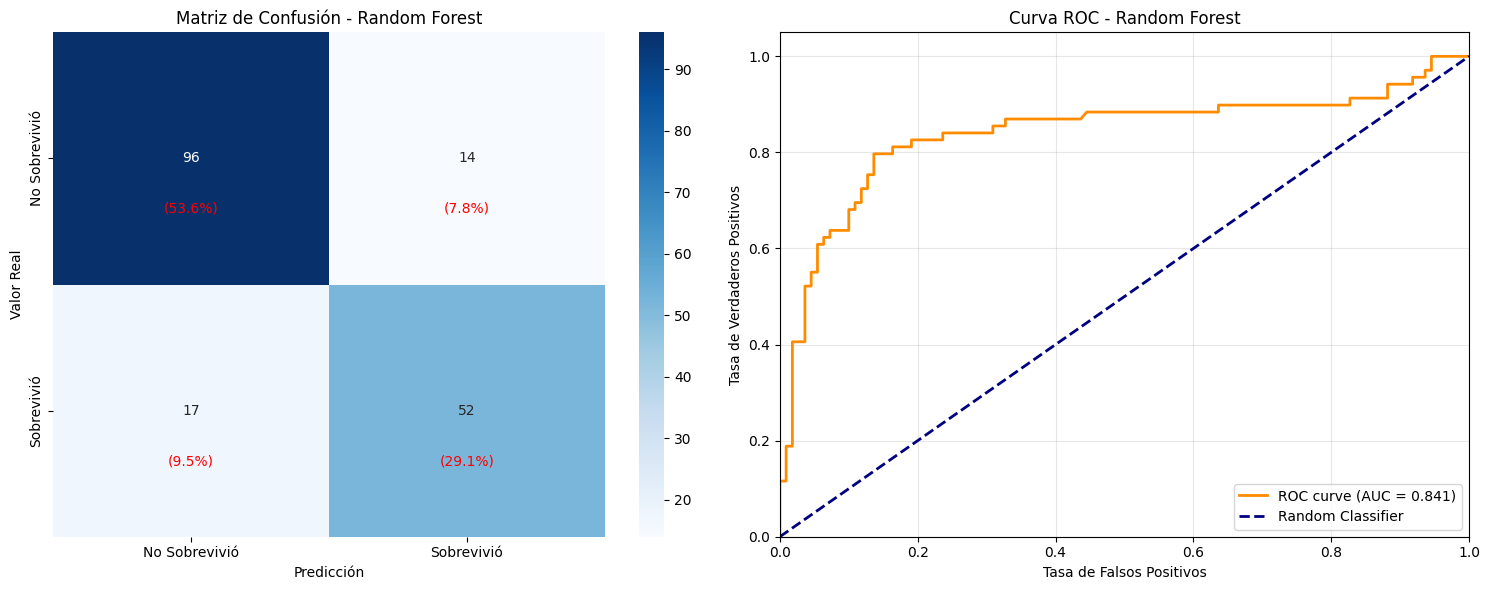


📊 Reporte de Clasificación Detallado:
               precision    recall  f1-score   support

No Sobrevivió       0.85      0.87      0.86       110
   Sobrevivió       0.79      0.75      0.77        69

     accuracy                           0.83       179
    macro avg       0.82      0.81      0.82       179
 weighted avg       0.83      0.83      0.83       179



In [110]:
# Matriz de Confusión y Gráfico ROC
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Random Forest')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Valor Real')
axes[0].set_xticklabels(['No Sobrevivió', 'Sobrevivió'])
axes[0].set_yticklabels(['No Sobrevivió', 'Sobrevivió'])

# Agregar porcentajes en la matriz
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / total * 100
        axes[0].text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='red')

# 2. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_rf:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curva ROC - Random Forest')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\n📊 Reporte de Clasificación Detallado:")
print("="*50)
print(classification_report(y_test, y_pred_rf, target_names=['No Sobrevivió', 'Sobrevivió']))

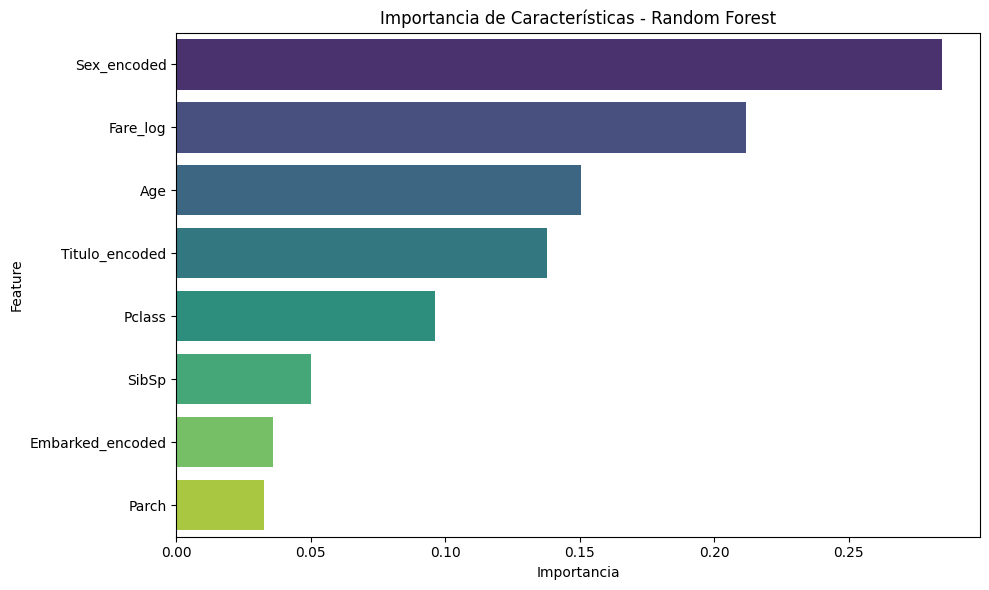

Importancia de Características:
Sex_encoded: 0.2847
Fare_log: 0.2120
Age: 0.1506
Titulo_encoded: 0.1379
Pclass: 0.0963
SibSp: 0.0500
Embarked_encoded: 0.0361
Parch: 0.0326
Resumen Final:
AUC-ROC: 0.8405
Accuracy: 0.8268


In [114]:
# Importancia de las características
feature_importance = pd.DataFrame({
    'Feature': X_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Importancia de Características - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

print("Importancia de Características:")
print("="*40)
for idx, row in feature_importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")
    
print(f"Resumen Final:")
print(f"AUC-ROC: {auc_rf:.4f}")
print(f"Accuracy: {accuracy_rf:.4f}")
